## Importing Libraries

In [ ]:
modules = "numpy,pandas,matplotlib,sklearn,fetch_openml,tqdm" # @param {type:"string"}
mods = modules.split(",")
for i in mods:
  if i=="numpy":
    import numpy as np
  if i=="pandas":
    import pandas as pd
  if i=="matplotlib":
    import matplotlib.pyplot as plt
  if i=="sklearn":
    import sklearn
  if i=="fetch_openml":
    from sklearn.datasets import fetch_openml
  if i=="tqdm":
    from tqdm import tqdm
  if i=="cupy":
    import cupy as np


## Dataset Preparation and EM

<div align="center">
  <img src="https://drive.google.com/uc?id=19RX1Icr9m4OH2r5kwnIIE-WqmT9LOpiN" alt="Example Image" style="border-radius: 30px;width:40px;">
</div>


### The E-step Function



```
def Estep(self):
    for i in range(len(self.X)):
      original_values = self.Pis * np.prod((((2*self.Probs.T)**(self.X[i][np.newaxis,:]))).T, axis=0) * np.prod((((2*(1 - self.Probs.T))**(1 - self.X[i][np.newaxis,:]))).T, axis=0)
      max_value = np.max(original_values)
      scaled_values = original_values / max_value
      sum_scaled_values = np.sum(scaled_values)
      normalized_values = scaled_values / sum_scaled_values
      self.gamma[i] = normalized_values
```




### The M-step Function



```
def Mstep(self):
    self.Pis = np.sum(self.gamma,axis=0)/len(self.X)
    Probsn = np.random.rand(len(self.clusters),len(self.X[0]))
    for k in range(len(self.clusters)):
        num = 0
        deno = 0
        for i in range(len(self.X)):
          num+=self.gamma[i][k]*self.X[i]
          deno+=self.gamma[i][k]
        Probsn[k] = num/deno
    self.Probs = Probsn.T.copy()
    del Probsn
```



In [ ]:
from sklearn.utils import resample

In [ ]:
class EMMNIST:
  def __init__(self,clusters):
    self.X,self.y,self.mnist,self.Pis, self.Probs,self.gamma = None, None, None, None, None, None
    self.clusters = clusters
    self.mus,self.clusterpoints = None,None
  def dataset_download(self):
    self.mnist = fetch_openml("mnist_784")
  def undersample_dataframe(self,df, label_column):
    counts = df[label_column].value_counts()
    min_count = counts.min()
    sampled_dfs = []
    for label, group in df.groupby(label_column):
        sampled_dfs.append(group.sample(min_count))
    return pd.concat(sampled_dfs)
  def initialize_data(self):
    (self.X,self.y) = (self.mnist.data,self.mnist.target)
    self.X["y"] = self.y
    self.X = self.undersample_dataframe(self.X,"y")
    self.X = self.X.drop("y",axis=1)
    self.X = self.X.to_numpy()
    self.X[self.X<128]=0
    self.X[self.X>=128]=1
    self.X = pd.DataFrame(self.X)
    self.X["y"] = self.y
    y_values = self.clusters
    self.X = self.X.query('y in @y_values')
    (self.X,self.y) = (self.X.drop("y",axis=1).to_numpy(),np.array(self.X["y"]))
    self.Pis = np.ones(len(self.clusters)) / len(self.clusters)
    self.Probs = np.random.rand(len(self.X[0]),len(self.clusters))
    self.gamma = np.zeros((len(self.X), len(self.clusters)))
  def plotdatapoint(self,i):
    plt.imshow(self.X[i].reshape(28,28),cmap='binary')
    plt.axis('off')
    plt.show()
  def Estep(self):
    for i in range(len(self.X)):
      original_values = self.Pis * np.prod((((2*self.Probs.T)**(self.X[i][np.newaxis,:]))).T, axis=0) * np.prod((((2*(1 - self.Probs.T))**(1 - self.X[i][np.newaxis,:]))).T, axis=0)
      max_value = np.max(original_values)
      scaled_values = original_values / max_value
      sum_scaled_values = np.sum(scaled_values)
      normalized_values = scaled_values / sum_scaled_values
      self.gamma[i] = normalized_values
  def Mstep(self):
    self.Pis = np.sum(self.gamma,axis=0)/len(self.X)
    Probsn = np.random.rand(len(self.clusters),len(self.X[0]))
    for k in range(len(self.clusters)):
        num = 0
        deno = 0
        for i in range(len(self.X)):
          num+=self.gamma[i][k]*self.X[i]
          deno+=self.gamma[i][k]
        Probsn[k] = num/deno
    self.Probs = Probsn.T.copy()
    del Probsn
  def train(self,max_iters=40,tolerance=1e-12):
    noofclusters,noofpoints = len(self.clusters),len(self.X)
    for iter in tqdm(range(max_iters)):
      Pis_old,Probs_old = self.Pis.copy(),self.Probs.copy()
      self.Estep()
      self.Mstep()
      if np.max(np.abs(self.Pis - Pis_old)) < tolerance and np.max(np.abs(self.Probs - Probs_old)) < tolerance:
        print("EM Algorithm Converged Successfully!!!")
        print(f"New Changes after training {max_iters} iterations are:")
        print((np.max(np.abs(self.Pis - Pis_old)),np.max(np.abs(self.Probs - Probs_old))))
        break
  def clusterize(self):
    bernoulli_points = self.X
    feat,temp,count = len(self.clusters),[],[]
    for i in range(feat):
      temp.append(np.zeros(784))
      count.append(0)
    for i in range(len(self.X)):
      temp[np.argmax(self.gamma[i])] = temp[np.argmax(self.gamma[i])] + self.X[i]
      count[np.argmax(self.gamma[i])]+=1
    self.mus = []
    for i in range(len(count)):
      self.mus.append(np.array(temp[i])/count[i])
    self.mus = np.array(self.mus)
    self.clusterpoints = np.array(count)
  def plotclusteraverages(self):
    indices = []
    for i in range(len(self.clusters)):
      indices.append(i+1)
    num_plots = len(indices)
    fig, axes = plt.subplots(1, num_plots, figsize=(15, 5))
    for ax, i in zip(axes, indices):
        result_image = self.mus[i-1]
        result_image = result_image.reshape(28, 28)
        ax.imshow(result_image, cmap='binary')
        ax.set_title(f'Cluster Average of Cluster {i}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
  def sample_multivariate_bernoulli(self,cluster):
    probabilities = self.Probs.T[cluster]
    probabilities = np.clip(probabilities, 0, 1)
    sample = np.random.rand(len(probabilities)) < probabilities
    return sample.astype(int)
  def gennewsamples(self,cluster):
    plt.imshow(self.sample_multivariate_bernoulli(cluster).reshape(28,28),cmap='binary')
    plt.title(f"The Generated Sample From Cluster {cluster}")
    plt.axis('off')
    plt.show()
  def generateallaverages(self,points):
    num_clusters = len(self.clusters)
    fig, axes = plt.subplots(1, num_clusters, figsize=(15, 3))
    for cluster_index in range(num_clusters):
        temp = np.zeros(784)
        for _ in range(points):
            temp += self.sample_multivariate_bernoulli(cluster_index)
        temp_avg = temp / points
        axes[cluster_index].imshow(temp_avg.reshape(28, 28), cmap='binary')
        axes[cluster_index].set_title(f'Cluster {cluster_index+1}')
        axes[cluster_index].axis('off')
    plt.show()


## Initializing the Estimator and Downloading the Data

In [ ]:
estimator = EMMNIST(['1','2','3','4','5','6','7','8','9','0'])
estimator.dataset_download()
estimator.initialize_data()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Training the Estimator

In [ ]:
MaxIterations = 80 # @param {type:"slider", min:0, max:100, step:1}
Tolerance = 1e-14 # @param {type:"slider", min:1e-14, max:1, step:1e-13}

estimator.train(max_iters=MaxIterations,tolerance=Tolerance)

100%|██████████| 40/40 [21:54<00:00, 32.87s/it]


## Clusterwise Averages

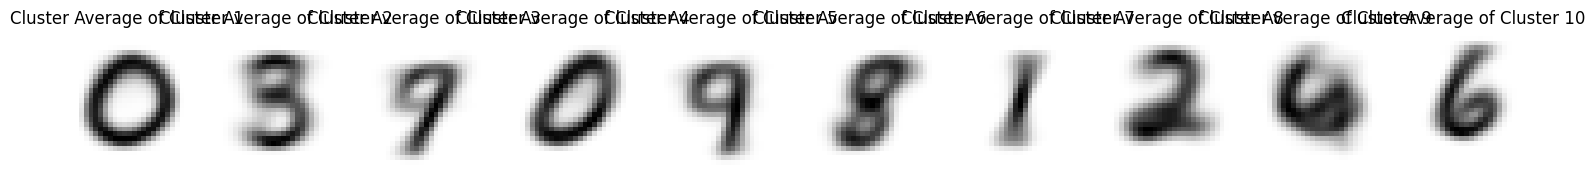

In [ ]:
estimator.clusterize()
estimator.plotclusteraverages()

## Averages of Generated Samples using probabilities obtained from EM

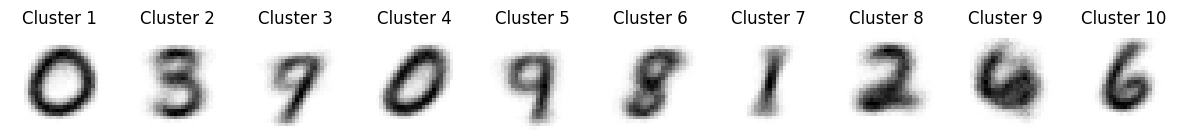

In [ ]:
NoOfPointsForAverage = 306 # @param {type:"slider", min:0, max:100000, step:1}
estimator.generateallaverages(NoOfPointsForAverage)

## Sample Generator

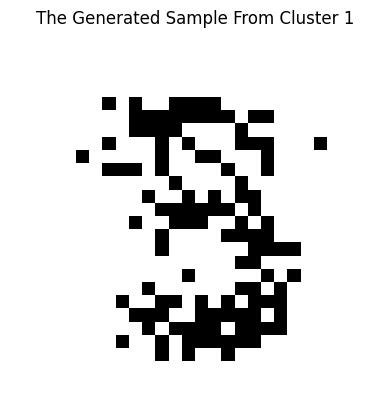

In [ ]:
Cluster = 2 # @param {type:"slider", min:1, max:10, step:1}
if (Cluster<=len(estimator.clusters)):
  estimator.gennewsamples(Cluster-1)
else:
  print("Please Enter A valid Value.")